In [93]:
import pandas as pd # for working with dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images
from scipy.interpolate import interp1d # for interpolating points
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import seaborn as sns # for plotting in seaborn

In [94]:
data_dir = "./leaves/" # set data directory
file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
file_names.remove('.DS_Store') # remove .DS_Store file
file_names.sort() # sort the list of file names
file_names # check list of file names

page_numbers = [] # get the page of the illustration
for i in range(len(file_names)):
    page_numbers.append(file_names[i][:file_names[i].index("_")])

plant_numbers = [] # get the individual plant
for i in range(len(file_names)):
    plant_numbers.append(file_names[i][file_names[i].index("_")+1:file_names[i].rfind("_")])

page_plant_IDs = [] # get page_plant_IDs
for i in range(len(file_names)):
    page_plant_IDs.append(file_names[i][:file_names[i].rfind("_")])

0
1


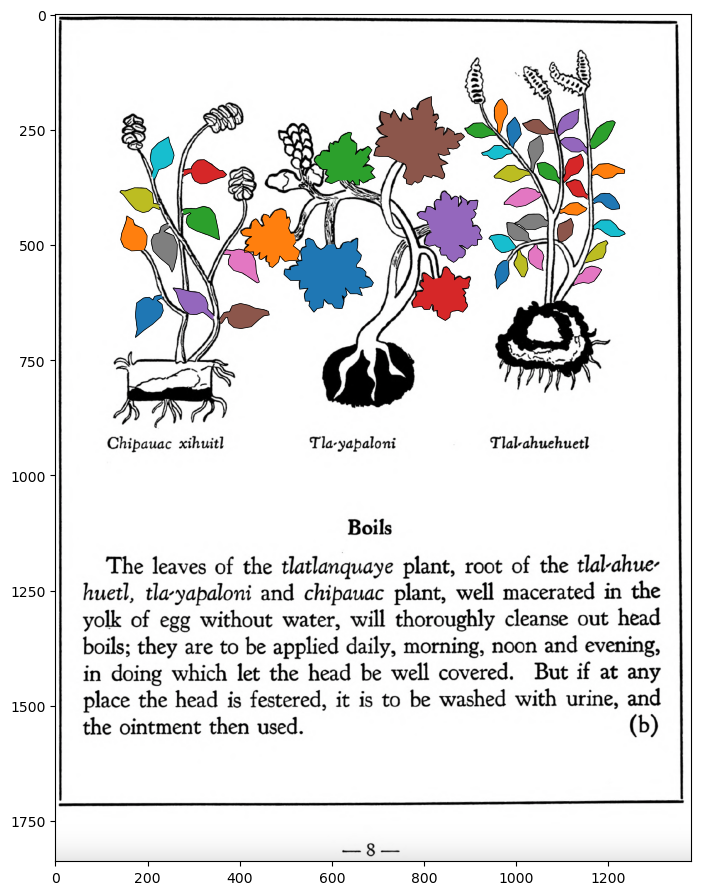

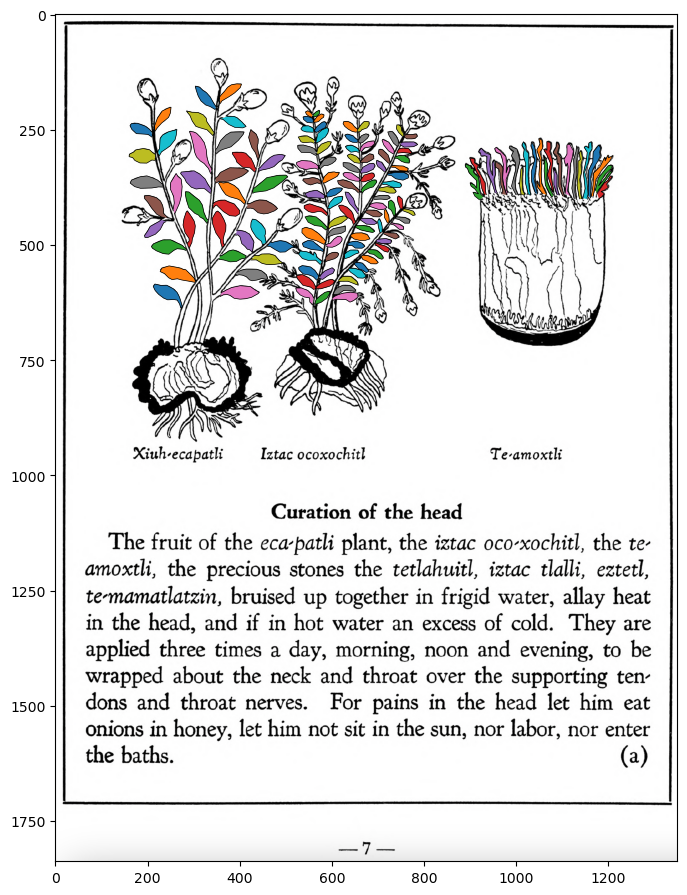

In [95]:
lo = "k" # leaf outline color
w = 0.5 # outline width
alfa = 1 # alpha

pic_dir = "./pics/" # set the directory of the pictures
save_dir = "./check/" # set the directory where to save image checks

unique_page_nums = list(set(page_numbers)) # get unique page numbers

for j in range(len(unique_page_nums)): # for each page
    print(j)

    curr_page = unique_page_nums[j] # get current page
    
    curr_image = pic_dir + curr_page + ".png" # get the current image to plot on
    
    plt.figure(figsize=(8.5,11)) # set figure size
    
    img = mpimg.imread(curr_image) # read in current image
    plt.imshow(img)
    
    for i in range(len(file_names)): # plot each leaf
        if curr_page in file_names[i]:
            lf = np.loadtxt(data_dir + file_names[i])
            plt.plot(lf[:,0], lf[:,1], c="k", lw=w)
            plt.fill(lf[:,0], lf[:,1], alpha=alfa)

    plt.savefig(save_dir+curr_page+".png") # save plot


In [96]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

In [97]:
# how many pseudo-landmarks
res = 50

# get page number and plant ID for each leaf
pg_num_list = []
pl_num_list = []
pl_ID_list = []

# an array to store pseudo-landmarks
lf_arr = np.zeros((len(file_names),res,2))

for i in range(len(file_names)): # for each leaf
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = file_names[i] # get current file name

    pg_num_list.append(page_numbers[i]) # get the page of the illustration
    pl_num_list.append(plant_numbers[i]) # get the individual plant
    pl_ID_list.append(page_plant_IDs[i]) # get the page_plant_ID

    lf_coords = np.loadtxt(data_dir + name) # load in leaf coordinates

    ###################################
    ### SPECIFY BASE AND TIP POINTS ###
    ###################################

    base_pt = lf_coords[0]
    tip_pt = lf_coords[-1]

    ###################
    ### INTERPOLATE ###
    ###################

    x_vals, y_vals = interpolation(lf_coords[:,0],lf_coords[:,1], res)
    lf_arr[i,:,:] = np.column_stack((x_vals, y_vals))

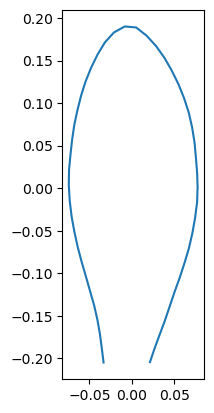

In [98]:
landmark_num = res # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(lf_arr, landmark_num, dim_num)

pca = PCA(n_components=2) # perform PCA to align along longest axis
pca = pca.fit_transform(mean_shape)

rot_x, rot_y = rotate_points(pca[:,0], pca[:,1], 180) # rotate mean leaf upwards
rot_mean = np.column_stack((rot_x, rot_y))

plt.plot(rot_mean[:,0], rot_mean[:,1]) # plot mean leaf
plt.gca().set_aspect("equal")

Text(0.5, 1.0, 'overall mean leaf')

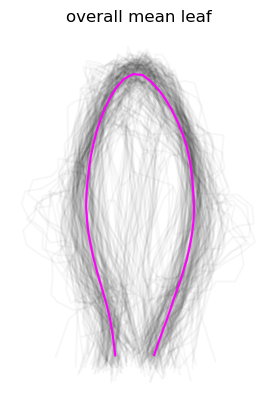

In [99]:
################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(lf_arr)) 

for i in range(len(lf_arr)):
    s1, s2, distance = procrustes(rot_mean, lf_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array

for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.03)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall mean leaf")


In [100]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = res*2 # PC number = res*2
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

PC: var, overall 
PC1: 41.8%, 41.8%
PC2: 21.8%, 63.6%
PC3: 15.8%, 79.4%
PC4: 4.6%, 84.0%
PC5: 3.6%, 87.7%
PC6: 2.9%, 90.6%
PC7: 2.6%, 93.2%
PC8: 1.4%, 94.5%
PC9: 1.0%, 95.5%
PC10: 0.7%, 96.2%
PC11: 0.6%, 96.8%
PC12: 0.5%, 97.3%
PC13: 0.4%, 97.7%
PC14: 0.4%, 98.0%
PC15: 0.3%, 98.3%
PC16: 0.2%, 98.5%
PC17: 0.2%, 98.7%
PC18: 0.2%, 98.9%
PC19: 0.2%, 99.0%
PC20: 0.1%, 99.1%
PC21: 0.1%, 99.3%
PC22: 0.1%, 99.4%
PC23: 0.1%, 99.4%
PC24: 0.1%, 99.5%
PC25: 0.1%, 99.6%
PC26: 0.1%, 99.6%
PC27: 0.0%, 99.7%
PC28: 0.0%, 99.7%
PC29: 0.0%, 99.7%
PC30: 0.0%, 99.8%
PC31: 0.0%, 99.8%
PC32: 0.0%, 99.8%
PC33: 0.0%, 99.8%
PC34: 0.0%, 99.9%
PC35: 0.0%, 99.9%
PC36: 0.0%, 99.9%
PC37: 0.0%, 99.9%
PC38: 0.0%, 99.9%
PC39: 0.0%, 99.9%
PC40: 0.0%, 99.9%
PC41: 0.0%, 99.9%
PC42: 0.0%, 99.9%
PC43: 0.0%, 99.9%
PC44: 0.0%, 100.0%
PC45: 0.0%, 100.0%
PC46: 0.0%, 100.0%
PC47: 0.0%, 100.0%
PC48: 0.0%, 100.0%
PC49: 0.0%, 100.0%
PC50: 0.0%, 100.0%
PC51: 0.0%, 100.0%
PC52: 0.0%, 100.0%
PC53: 0.0%, 100.0%
PC54: 0.0%, 100.0%
PC55:

In [101]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # keep to 2 for now for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting

mdata = pd.DataFrame({
    "page":pg_num_list,
    "plant":pl_num_list,
    "ID":pl_ID_list,
    "PC1":PCs[:,0],
    "PC2":PCs[:,1]}
)

PC: var, overall 
PC1: 41.8%, 41.8%
PC2: 21.8%, 63.6%


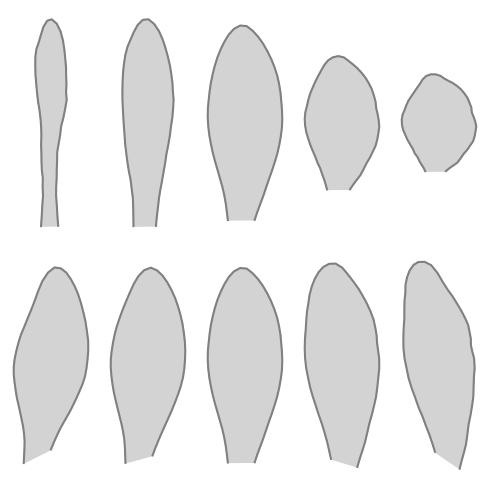

In [102]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 2 PCs ###
###################################################

# calculate standard deviations for each PC
PC1_std = mdata["PC1"].std()
PC2_std = mdata["PC2"].std()

# create list of lists of PC values to reconstruct
PC_vals = [[-2*PC1_std,0],
           [-1*PC1_std,0],
           [0*PC1_std,0],
           [1*PC1_std,0],
           [2*PC1_std,0],
           [0,-2*PC2_std],
           [0,-1*PC2_std],
           [0,0*PC2_std],
           [0,1*PC2_std],
           [0,2*PC2_std],
]

plt.figure(figsize=(5,5))

counter = 1

for i in range(len(PC_vals)):
    
    # create inverse leaf
    inv_leaf = pca.inverse_transform(np.array(PC_vals[i]))
    inv_x = inv_leaf[0::2] # select just inverse x vals
    inv_y = inv_leaf[1::2] # select just inverse y vals
    
    # plot inverse leaf
    plt.subplot(2,5,counter)
    plt.fill(inv_x, inv_y, c="lightgray")
    plt.plot(inv_x, inv_y, c="gray")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    counter += 1

plt.tight_layout()

Text(0.5, 1.0, 'Procrustean morphospace')

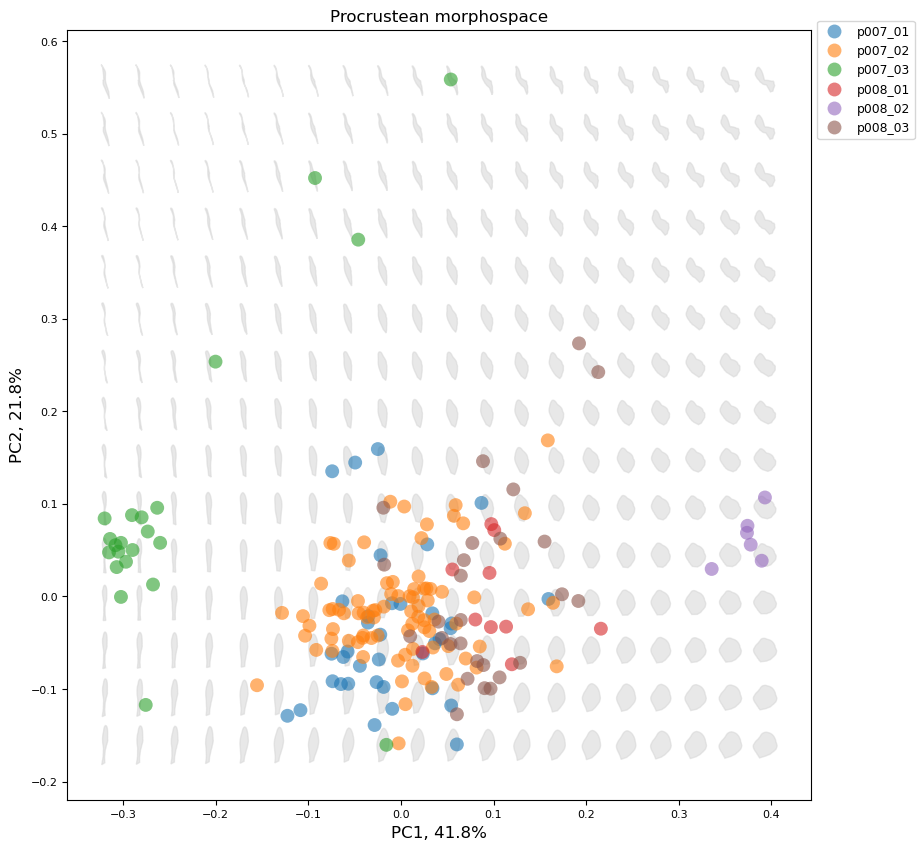

In [103]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 20 # set number of PC1 intervals
numPC2 = 15 # set number of PC2 intervals
hue = "ID" # select the factor to color by
s = 0.08 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 100 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC1", y="PC2", hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)